This notebook is to demonstrate applying Kalman Filter on the environment

Replace the variable *PATH_TO_ROOT* to run the notebook 

In [1]:
import sys

PATH_TO_ROOT = 'C:/Users/walter/Desktop/git/AlphaBuilding_testbed'
sys.path.insert(0,PATH_TO_ROOT)

In [2]:
import pandas as pd
import numpy as np
from datetime import date, timedelta
import matplotlib.pyplot as plt

from pykalman import KalmanFilter

from gym_AlphaBuilding.envs import residential
from util.distribution import utility
from util.weather import noaa_weather

In [3]:
plt.rc('xtick', labelsize=14, color='grey')
plt.rc('ytick', labelsize=14, color='grey')
plt.rc('axes', titlesize=22)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('legend', fontsize=16)
plt.rc('savefig', dpi=330, bbox='tight')

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
%reload_ext autoreload

In [5]:
def generate_fig_name(fig_name):
    '''
    Generate the figure path and name
    To be used by plt.savefig function
    '''
    return '{}/results/fig/other_heat_gain/{}'.format(PATH_TO_ROOT, fig_name)

## Prepare the environment

In [6]:
city = 'Berkeley'
state = 'CA'

start_date = date(2018,8,1)
final_date = date(2018,8,3)

SAMPLE_SIZE = 2
STEP_SIZE = 15 # min
sim_horizon = (str(start_date), str(final_date))

In [7]:
# Download weather data from NOAA weather stations
# If you want to use your own weather data, skip this step
address = '{}, {}'.format(city, state)
station_ids, station_names = noaa_weather.find_closest_weather_station(noaa_weather.geocode_address(address))

# You might need to try a couple of weather stations, because some weather stations have large missing rate 
weather = noaa_weather.download_weather(station_ids[0], start_date.year)
weather = weather.tz_convert('America/Los_Angeles').tz_localize(None)  # remove tz-awareness

# truncate and resample the weather data to fit the simulation horizon and time step
weather_h = weather.resample('1H').mean()  # hourlu average to remove noise
weather_ts = weather_h.resample('{}min'.format(STEP_SIZE)).interpolate()
weather_ts = weather_ts.truncate(*sim_horizon)

In [8]:
weather_input = weather_ts
weather_input['Temperature'] = weather_input['Temperature']+10

In [9]:
# Retrieve the parameters
ttc = utility.get_ttc(state)
teq = utility.get_teq(state)
tsp, trange = utility.get_comfort_temp('cooling', 'ASHRAE PMV')

In [10]:
class controller_RBC():
    def __init__(self, t_lower, t_upper):
        self.t_lower = t_lower
        self.t_upper = t_upper
    
    def action(self, t, a=0):
        if t < self.t_lower:
            action = 0
        elif t > self.t_upper:
            action = 2    # 2 for cooling
        else:
            action = a
        return action

t_lower = tsp[0]-1
t_upper = tsp[0]+1.5
    
controller = controller_RBC(t_lower, t_upper)

In [11]:
noise_sigma = 0.03

In [12]:
np.random.seed(1)

env = residential.AlphaResEnv(sample_size  = SAMPLE_SIZE, 
                           step_size    = STEP_SIZE, 
                           sim_horizon  = sim_horizon,
                           ambient_weather = weather_input, 
                           ttc = ttc, 
                           teq = teq, 
                           tsp = tsp, 
                           trange = trange,
                           hvac_mode = 'cooling only',
                           otherHG_method = 'Ecobee',
                           noise_sigma = noise_sigma,
                           cost_weight = (10, 1),
                           measurement_error_sigma = 0.5)

C:\Users\walter\Anaconda3\envs\ecobee_env\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [13]:
# Simulate

np.random.seed(1)

obs = env.reset()
act_previous = [0]*SAMPLE_SIZE

T_in = pd.DataFrame(index=env.t_index[:-1], columns = list(range(SAMPLE_SIZE)))
T_amb = pd.DataFrame(index=env.t_index[:-1], columns = list(range(SAMPLE_SIZE)))
Action = pd.DataFrame(index=env.t_index[:-1], columns = list(range(SAMPLE_SIZE)))
IntHG = pd.DataFrame(index=env.t_index[:-1], columns = list(range(SAMPLE_SIZE)))
SolHG = pd.DataFrame(index=env.t_index[:-1], columns = list(range(SAMPLE_SIZE)))
Noise = pd.DataFrame(index=env.t_index[:-1], columns = list(range(SAMPLE_SIZE)))
Error = pd.DataFrame(index=env.t_index[:-1], columns = list(range(SAMPLE_SIZE)))

for time in T_in.index:
    t_in = obs[-SAMPLE_SIZE:]
    t_amb = [obs[0]]*SAMPLE_SIZE
    action = [0]*SAMPLE_SIZE
    for i in range(SAMPLE_SIZE):
        action[i] = controller.action(t_in[i], act_previous[i])
    obs,_,_,comments = env.step(action)
    intHG = comments['intHG']
    solHG = comments['solHG']
    noise = comments['noise']
    error = comments['error']
    T_in.loc[time] = t_in
    T_amb.loc[time] = t_amb
    Action.loc[time] = action
    IntHG.loc[time] = intHG
    SolHG.loc[time] = solHG
    Noise.loc[time] = noise
    Error.loc[time] = error
    act_previous = action

Episode: 1
Total Energy Consumption (kWh)
94.4021802666906
Total Uncomfortable Degree Hours (K*h)
21.659693514796807


In [33]:
comments['Energy']

94.4021802666906

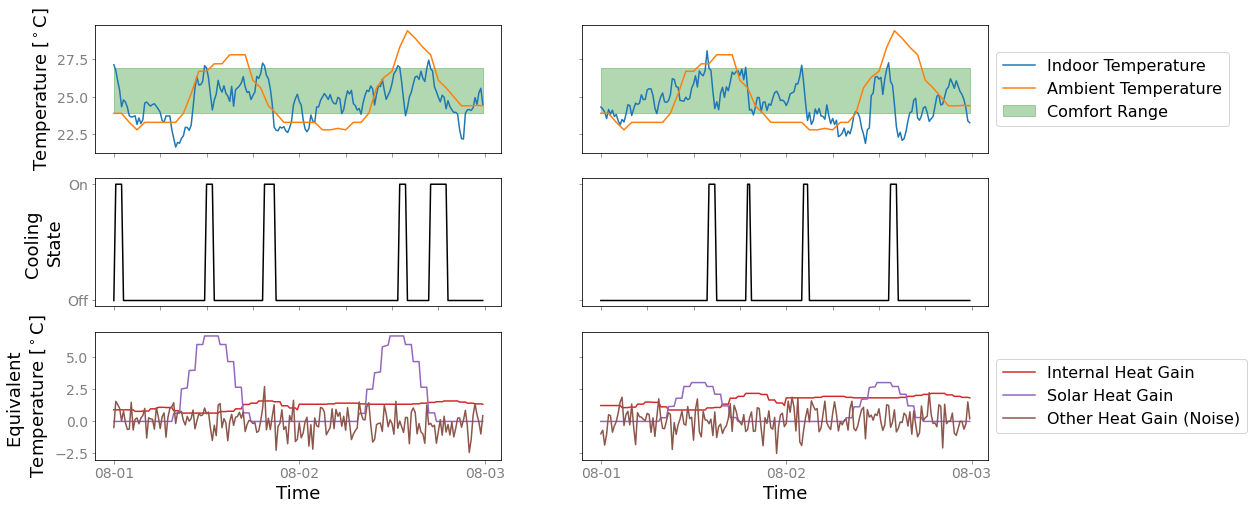

In [14]:
# Plot simulation result

fig, axs = plt.subplots(3, SAMPLE_SIZE, figsize=(16,8))

for i in range(SAMPLE_SIZE):
    axs[0,i].plot(T_in.index, T_in[i].values, label='Indoor Temperature', c=default_colors[0])
    axs[0,i].plot(T_amb.index, T_amb[i].values, label='Ambient Temperature', c=default_colors[1])
    axs[0,i].fill_between(T_amb.index, controller.t_lower-0.5, controller.t_upper, \
                     label='Comfort Range', color='green', alpha=0.3)

    axs[1,i].plot(Action.index, Action[i].values/2, c='black')

    axs[2,i].plot(IntHG.index, IntHG[i].values, label='Internal Heat Gain', c=default_colors[3])
    axs[2,i].plot(SolHG.index, SolHG[i].values, label='Solar Heat Gain', c=default_colors[4])
    axs[2,i].plot(Noise.index, Noise[i].values, label='Other Heat Gain (Noise)', c=default_colors[5])

axs[2,0].set_xlabel('Time')
axs[2,1].set_xlabel('Time')
xtick_frequency = 4
locs, _ = plt.xticks()
axs[2,0].set_xticks(locs[::xtick_frequency])
axs[2,0].set_xticklabels(['08-01','08-02','08-03'])
axs[2,1].set_xticks(locs[::xtick_frequency])
axs[2,1].set_xticklabels(['08-01','08-02','08-03'])
    
axs[0,0].sharey(axs[0, 1])
axs[0,0].set_ylabel('Temperature [$^\circ$C]')

axs[1,0].sharey(axs[1, 1])
axs[1,0].set_ylabel('Cooling \nState')
axs[1,0].set_yticks([0, 1])
axs[1,0].set_yticklabels(['Off','On'])

axs[2,0].sharey(axs[2, 1])
axs[2,0].set_ylim(-3, 7)
axs[2,0].set_ylabel('Equivalent \nTemperature [$^\circ$C]')

axs[0,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[2,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

for ax in fig.get_axes():
    ax.label_outer()
    
plt.savefig(generate_fig_name('onOffController'))

In [15]:
env.R

array([5.08979259, 1.08554326])

In [16]:
env.Ttc/env.R

array([ 4.8652001 , 10.85543258])

In [17]:
env.Teq

array([8.41668491, 5.29162431])

In [18]:
measurements = T_in.values.astype(np.float)
measurements.shape

(192, 2)

In [19]:
transition_offset_intHG = (1-env.A)*(T_amb.values + IntHG.values + SolHG.values + \
                    env.R*env.Q_c*Action.values/2)
transition_offset_intHG = transition_offset_intHG.astype(np.float)
transition_offset_intHG.shape

transition_offset_tempOnly = (1-env.A)*(T_amb.values + env.R*env.Q_c*Action.values/2)
transition_offset_tempOnly = transition_offset_tempOnly.astype(np.float)
transition_offset_tempOnly.shape

(192, 2)

In [20]:
transition_matrice = np.diag(env.A)   # Because env.A is an array
transition_matrice

array([[0.98995503, 0.        ],
       [0.        , 0.97900833]])

In [21]:
observation_matrice = np.eye(len(env.A))
observation_matrice

array([[1., 0.],
       [0., 1.]])

In [22]:
# Sensible defaults values are given for all unspecified parameters 
# zeros for all 1-dimensional arrays 
# identity matrices for all 2-dimensional arrays

kf_intHG = KalmanFilter(transition_matrices = transition_matrice, 
                  observation_matrices = observation_matrice, 
                  initial_state_mean = measurements[0,:],
                  transition_covariance = np.eye(len(env.A))*(noise_sigma/2.5*(60*15)**0.5)**2,
                  observation_covariance = np.eye(len(env.A))*0.5,
                  transition_offsets = transition_offset_intHG)
kf_intHG = kf_intHG.em(measurements, n_iter=5)

kf_tempOnly = KalmanFilter(transition_matrices = transition_matrice, 
                  observation_matrices = observation_matrice, 
                  initial_state_mean = measurements[0,:],
                  transition_covariance = np.eye(len(env.A))*(noise_sigma/2.5*(60*15)**0.5)**2,
                  observation_covariance = np.eye(len(env.A))*0.5,
                  transition_offsets = transition_offset_tempOnly)
kf_tempOnly = kf_tempOnly.em(measurements, n_iter=5)

In [23]:
(smoothed_state_means_intHG, smoothed_state_covariances_intHG) = kf_intHG.smooth(measurements)

(smoothed_state_means_tempOnly, smoothed_state_covariances_tempOnly) = kf_tempOnly.smooth(measurements)

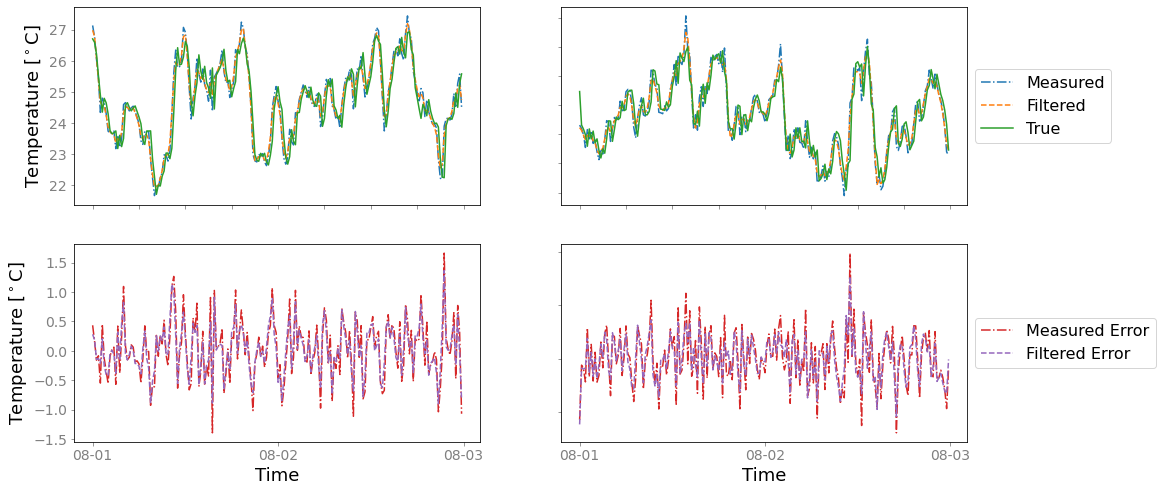

In [24]:
# Plot Kalman Filter
Error_filter = smoothed_state_means_tempOnly - (T_in.values-Error.values)

xtick_frequency = 4
fig, axs = plt.subplots(2, SAMPLE_SIZE, figsize=(16,8))

for i in range(SAMPLE_SIZE):
    axs[0,i].plot(T_in.index, T_in[i].values, label='Measured', c=default_colors[0], linestyle='-.')
    axs[0,i].plot(T_amb.index, smoothed_state_means_tempOnly[:,i], label='Filtered', c=default_colors[1], linestyle='--')
    axs[0,i].plot(T_in.index, T_in[i].values-Error[i].values, label='True', c=default_colors[2])

    axs[1,i].plot(T_in.index, Error[i].values, label='Measured Error', c=default_colors[3], linestyle='-.')
    axs[1,i].plot(T_in.index, Error_filter[:,i], label='Filtered Error', c=default_colors[4], linestyle='--')
    
    axs[1,i].set_xlabel('Time')

locs, _ = plt.xticks()
axs[1,0].set_xticks(locs[::xtick_frequency])
axs[1,0].set_xticklabels(['08-01','08-02','08-03'])
axs[1,1].set_xticks(locs[::xtick_frequency])
axs[1,1].set_xticklabels(['08-01','08-02','08-03'])

axs[0,0].sharex(axs[0,1])
axs[0,0].set_ylabel('Temperature [$^\circ$C]')
axs[1,0].sharex(axs[1,1])
axs[1,0].set_ylabel('Temperature [$^\circ$C]')

axs[0,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[1,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

for ax in fig.get_axes():
    ax.label_outer()

plt.savefig(generate_fig_name('filter tempOnly'))

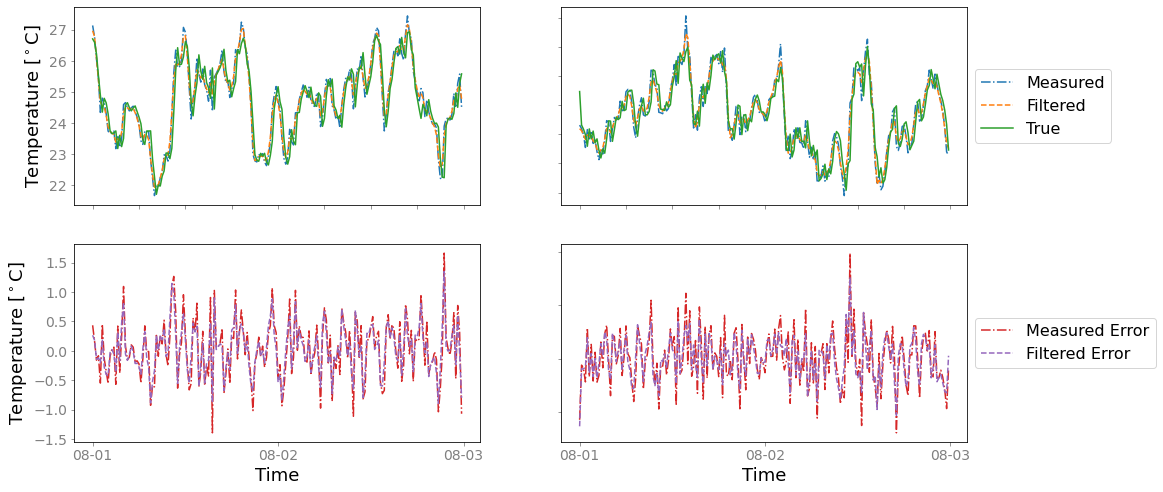

In [25]:
# Plot Kalman Filter
Error_filter = smoothed_state_means_intHG - (T_in.values-Error.values)

xtick_frequency = 4
fig, axs = plt.subplots(2, SAMPLE_SIZE, figsize=(16,8))

for i in range(SAMPLE_SIZE):
    axs[0,i].plot(T_in.index, T_in[i].values, label='Measured', c=default_colors[0], linestyle='-.')
    axs[0,i].plot(T_amb.index, smoothed_state_means_intHG[:,i], label='Filtered', c=default_colors[1], linestyle='--')
    axs[0,i].plot(T_in.index, T_in[i].values-Error[i].values, label='True', c=default_colors[2])

    axs[1,i].plot(T_in.index, Error[i].values, label='Measured Error', c=default_colors[3], linestyle='-.')
    axs[1,i].plot(T_in.index, Error_filter[:,i], label='Filtered Error', c=default_colors[4], linestyle='--')
    
    axs[1,i].set_xlabel('Time')

locs, _ = plt.xticks()
axs[1,0].set_xticks(locs[::xtick_frequency])
axs[1,0].set_xticklabels(['08-01','08-02','08-03'])
axs[1,1].set_xticks(locs[::xtick_frequency])
axs[1,1].set_xticklabels(['08-01','08-02','08-03'])

axs[0,0].sharex(axs[0,1])
axs[0,0].set_ylabel('Temperature [$^\circ$C]')
axs[1,0].sharex(axs[1,1])
axs[1,0].set_ylabel('Temperature [$^\circ$C]')

axs[0,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[1,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

for ax in fig.get_axes():
    ax.label_outer()

plt.savefig(generate_fig_name('filter intHG'))

In [26]:
Error.std()

0    0.505758
1    0.517093
dtype: float64

In [27]:
Error_filter[:,0].std()

0.4055575593367565

In [28]:
Error_filter[:,1].std()

0.40064131733741454